# Customer Analysis
Cohort Analysis, Retention, Lifetime Value & RFM Analysis using Machine Learning
---

**Analysis:**

Create different cohorts depending on user's creation date and determine which customer should have bought or not something. The machine learning model is being used to predict what users should have bought but didnt. We are not tryning to forecast what they will be doing next but what they should have done in the past. 

**Useful links:**
- [Step-by-step video guide. Youtube](https://www.youtube.com/watch?v=s-32u6XdY7c)
- [What is RFM analysis. Youtube](https://www.youtube.com/watch?v=guj2gVEEx4s)
- [Improve Random Forest Hyperparameters](https://towardsdatascience.com/random-forest-hyperparameters-and-how-to-fine-tune-them-17aee785ee0d#:~:text=The%20most%20important%20hyper%2Dparameters,MSE%20or%20MAE%20for%20regression)

**Questions to answer:**
- 1. Which customers have a high top up probability but didnt do anything in the next 30 days. 
- 2. Which customers have recently topped up but are unlikely to buy. (Recency vs y_pred)
- 3. Which customers with high spending had a low probability of doing it again. (Study to improve business)

In [5]:
# Imports and general settings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

pd.set_option('display.max_columns', None)

## Data Wrangling and EDA

In [6]:
# Reading csv file
df = pd.read_csv('../trash/topup.csv')

In [7]:
df = df[['transactionid', 'aug_created_date', 'clear_txn_method', '$ USD', 'userid', 'User_Creation_Date']]

In [8]:
df.columns = ['txn_id', 'txn_date', 'txn_type', 'amount_usd', 'user_id', 'user_date']

In [9]:
df

,txn_id,txn_date,txn_type,amount_usd,user_id,user_date
0,b1334598-970a-4936-a535-818689761705,2022-10-27 00:00:00,MPESA load,12.42,b74a52e3-4160-933d-c653-644c3826e1bb,2022-09-18 00:00:00
1,513d6960-b689-424a-970d-9e0f20f36f44,2022-10-27 00:00:00,load using bank card,13.61,86611122-811a-5480-407d-daefaf2a42c2,2022-10-07 00:00:00
2,91d42b18-7e04-4be3-be9d-2b7e6734aa36,2022-10-27 00:00:00,load using bank card,1361.25,4d25ec74-1c5e-6b8e-83c4-f4893bfc7147,2022-09-30 00:00:00
3,025af1e7-3f13-4925-b554-f61683dd656a,2022-10-27 00:00:00,load using bank card,90.11,78440d56-048f-3698-1aa0-5bf01029da90,2022-10-26 00:00:00
4,9884ceae-818a-4f23-b126-0aab20b5b47f,2022-10-27 00:00:00,load using bank card,13.61,86611122-811a-5480-407d-daefaf2a42c2,2022-10-07 00:00:00
...,...,...,...,...,...,...
165609,5f40af98-8e7d-4640-b4e1-40662109f39b,2019-10-30 00:00:00,load using bank card,14.57,6823f09f-c6d5-19b4-a3d3-fcb9fa3a231e,2019-03-09 00:00:00
165610,2da643e1-fb9c-4e2b-aec5-a1f4061e138f,2019-10-30 00:00:00,load using bank card,14.28,6823f09f-c6d5-19b4-a3d3-fcb9fa3a231e,2019-03-09 00:00:00
165611,57d66422-ad89-4552-b766-b42c31bcc5ca,2019-10-30 00:00:00,load using bank card,2.85,6823f09f-c6d5-19b4-a3d3-fcb9fa3a231e,2019-03-09 00:00:00
165612,b1e15e8e-8cdd-4080-8da0-d5f7ec500e06,2019-10-30 00:00:00,load using bank card,3.13,6823f09f-c6d5-19b4-a3d3-fcb9fa3a231e,2019-03-09 00:00:00


In [10]:
df['txn_date'] = pd.to_datetime(df['txn_date'], format='%Y-%m-%d %H:%M:%S')
df['user_date'] = pd.to_datetime(df['user_date'], format='%Y-%m-%d %H:%M:%S')
df['txn_type'] = df['txn_type'].astype('category')
#df['user_status'] = df['user_status'].astype('category')
df['txn_date_ym'] = df['txn_date'].apply(lambda x: x.to_period('M'))
df['user_date_ym'] = df['user_date'].apply(lambda x: x.to_period('M'))
#df['txn_date_ym'] = df.apply(lambda x: str(x['txn_date'].year) + '-' + ('0' + str(x['txn_date'].month))[-2:], axis=1)
#df['user_date_ym'] = df.apply(lambda x: str(x['user_date'].year) + '-' + ('0' + str(x['user_date'].month))[-2:], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165614 entries, 0 to 165613
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   txn_id        165614 non-null  object        
 1   txn_date      165614 non-null  datetime64[ns]
 2   txn_type      165614 non-null  category      
 3   amount_usd    165614 non-null  float64       
 4   user_id       165614 non-null  object        
 5   user_date     165614 non-null  datetime64[ns]
 6   txn_date_ym   165614 non-null  period[M]     
 7   user_date_ym  165614 non-null  period[M]     
dtypes: category(1), datetime64[ns](2), float64(1), object(2), period[M](2)
memory usage: 9.0+ MB


In [12]:
ke = df[df['txn_type'] == 'MPESA load']
ae = df[df['txn_type'] == 'load using bank card']

## Cohorts Analysis

### UAE

In [13]:
# For UAE, The highest number of users signup is between 2021-10 and 2022-06
ae[['user_date_ym', 'user_id']].groupby('user_date_ym').count().sort_index().T

user_date_ym,2019-02,2019-03,2019-05,2019-07,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10
user_id,7,38,27,1,3,3,35,294,10,29,68,270,159,349,294,402,718,264,428,514,863,1478,1308,690,472,1358,1773,3635,3892,4692,7455,13335,35386,12546,7387,3367,2057,1831,1721,1612,1289,970


In [14]:
orders_per_user = ae.groupby('user_id')['txn_id'].nunique()
multiple_orders_user = np.sum(orders_per_user > 1) / ae.user_id.nunique()
print('More than half of the customers have made 2 or more orders:', f'{round(100*multiple_orders_user, 2)}%')

More than half of the customers have made 2 or more orders: 60.8%


<AxesSubplot:>

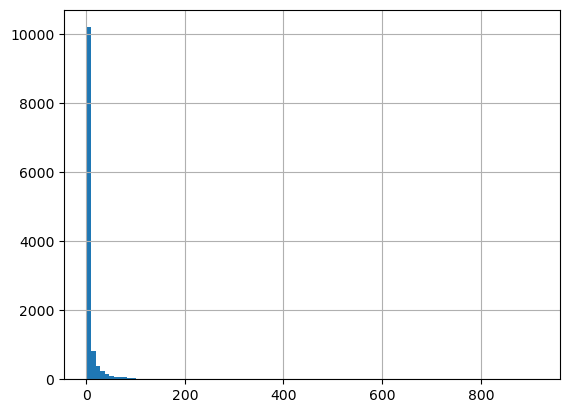

In [15]:
orders_per_user.hist(bins=100)

In [16]:
# Right (Positive) Skewed distribution. Most of the customers performed 5 or less topups.
# There outliers worth investigating such as 1514bdfe-70af-01d8-2df3-748455374d42 with a total of 915 topups.
orders_per_user.sort_values(ascending=False).head()

user_id
1514bdfe-70af-01d8-2df3-748455374d42    915
4ef776d3-97b7-5ce6-ed5b-72bc36b291a1    786
353c1071-d080-af16-e959-ceaaafe66137    528
6712a909-ff60-9aa3-19b7-270721fe21d6    520
dc6409c3-634c-e8b8-de5c-bce69571fb43    422
Name: txn_id, dtype: int64

In [17]:
#ae['cohort'] = ae.groupby('user_id')['user_date'].transform('min').dt.to_period('M')

In [18]:
# create a new column using the agg function. the new column name will be n_customers.
ae_cohort = ae.groupby(['user_date_ym', 'txn_date_ym'])[['user_id']].agg(n_customers=('user_id', 'nunique')) \
                                                                        .reset_index(drop=False)

In [19]:
# This cell and the one below compute the same thing, the number of months between the creation date and transaction date.

#from operator import attrgetter
#ae_cohort['period'] = (ae_cohort.txn_month - ae_cohort.cohort).apply(attrgetter('n'))

In [20]:
# Use period to change the cohort arrangement, every period equals one month here.
ae_cohort['period'] = ae_cohort \
.apply(lambda x: (x.txn_date_ym.year - x.user_date_ym.year) * 12 + (x.txn_date_ym.month  - x.user_date_ym.month), axis=1)

In [21]:
ae_cohort = ae_cohort[(ae_cohort.user_date_ym >= '2022-01') & (ae_cohort.period >= 0)].reset_index(drop=True)

In [22]:
ae_cohort.head(3)

,user_date_ym,txn_date_ym,n_customers,period
0,2022-01,2022-01,1212,0
1,2022-01,2022-02,629,1
2,2022-01,2022-03,340,2


In [23]:
cohort_pivot_period = ae_cohort.pivot_table(index = 'user_date_ym', columns = 'period', values = 'n_customers')
cohort_pivot_by_txn = ae_cohort.pivot_table(index = 'user_date_ym', columns = 'txn_date_ym', values = 'n_customers')

In [24]:
cohort_pivot_period

period,0,1,2,3,4,5,6,7,8,9
user_date_ym,,,,,,,,,,
2022-01,1212.0,629.0,340.0,234.0,113.0,78.0,79.0,72.0,43.0,40.0
2022-02,641.0,343.0,232.0,101.0,70.0,67.0,63.0,41.0,39.0,NaN
2022-03,574.0,297.0,151.0,96.0,84.0,75.0,60.0,65.0,NaN,NaN
2022-04,498.0,233.0,134.0,114.0,103.0,83.0,88.0,NaN,NaN,NaN
2022-05,364.0,167.0,124.0,100.0,75.0,76.0,NaN,NaN,NaN,NaN
2022-06,327.0,153.0,112.0,100.0,81.0,NaN,NaN,NaN,NaN,NaN
2022-07,360.0,183.0,116.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-08,398.0,176.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09,430.0,218.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
cohort_pivot_by_txn

txn_date_ym,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10
user_date_ym,,,,,,,,,,
2022-01,1212.0,629.0,340.0,234.0,113.0,78.0,79.0,72.0,43.0,40.0
2022-02,NaN,641.0,343.0,232.0,101.0,70.0,67.0,63.0,41.0,39.0
2022-03,NaN,NaN,574.0,297.0,151.0,96.0,84.0,75.0,60.0,65.0
2022-04,NaN,NaN,NaN,498.0,233.0,134.0,114.0,103.0,83.0,88.0
2022-05,NaN,NaN,NaN,NaN,364.0,167.0,124.0,100.0,75.0,76.0
2022-06,NaN,NaN,NaN,NaN,NaN,327.0,153.0,112.0,100.0,81.0
2022-07,NaN,NaN,NaN,NaN,NaN,NaN,360.0,183.0,116.0,100.0
2022-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,398.0,176.0,124.0
2022-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,218.0


In [26]:
cohort_size = ae.groupby('user_date_ym').agg(cohort_size=('user_id', 'nunique'))['2022-01':]
cohort_size

,cohort_size
user_date_ym,
2022-01,1521
2022-02,837
2022-03,787
2022-04,686
2022-05,536
2022-06,477
2022-07,458
2022-08,494
2022-09,528


In [27]:
retention_matrix = cohort_pivot_by_txn.apply(lambda x: x.div(cohort_size.values.flatten()), axis=0)

In [28]:
retention_matrix

txn_date_ym,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10
user_date_ym,,,,,,,,,,
2022-01,0.796844,0.413544,0.223537,0.153846,0.074293,0.051282,0.051940,0.047337,0.028271,0.026298
2022-02,NaN,0.765830,0.409797,0.277180,0.120669,0.083632,0.080048,0.075269,0.048984,0.046595
2022-03,NaN,NaN,0.729352,0.377382,0.191868,0.121982,0.106734,0.095299,0.076239,0.082592
2022-04,NaN,NaN,NaN,0.725948,0.339650,0.195335,0.166181,0.150146,0.120991,0.128280
2022-05,NaN,NaN,NaN,NaN,0.679104,0.311567,0.231343,0.186567,0.139925,0.141791
2022-06,NaN,NaN,NaN,NaN,NaN,0.685535,0.320755,0.234801,0.209644,0.169811
2022-07,NaN,NaN,NaN,NaN,NaN,NaN,0.786026,0.399563,0.253275,0.218341
2022-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.805668,0.356275,0.251012
2022-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.814394,0.412879


### Plotting Retention Matrix. Conclusions.

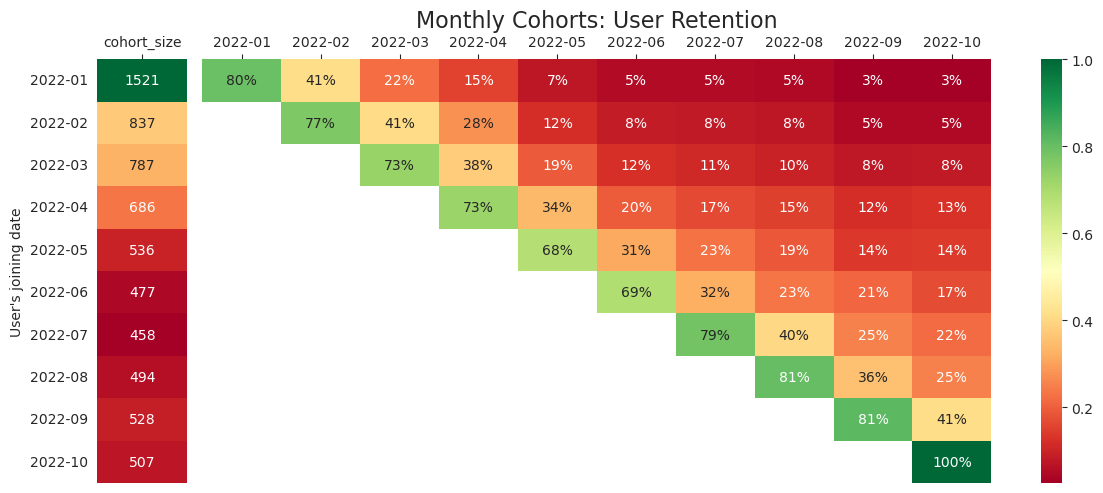

In [29]:
# Since January is the month with more new users (1212), this is the one we will use to train and test the model. 
# Notice first month (period) do not add up to 100% because there are users that didnt do anyhting the month they joined.

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16) 
    ax[1].set(xlabel='', ylabel='')
    ax[1].xaxis.set_label_position('top') # Sets x label name at the top
    ax[1].xaxis.tick_top() # Set x ticks at the top
    
    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g',
                cmap='RdYlGn',
                ax=ax[0])
    ax[0].set_ylabel("User's joining date")
    ax[0].xaxis.tick_top()
    fig.tight_layout()

## Single Cohort Analysis - January 2022
## Machine learning prediction

### Creating cohort and EDA

In [30]:
cohort = '2022-01'
co = ae[ae['user_date_ym'] == cohort][['txn_id', 'user_id', 'txn_date', 'txn_date_ym', 'amount_usd']].reset_index(drop=True)

In [31]:
co_summary = co.groupby('txn_date_ym').agg({'txn_id': 'count', 'user_id': 'nunique', 'amount_usd': 'mean'})
co_summary

,txn_id,user_id,amount_usd
txn_date_ym,,,
2022-01,15736,1212,300.209643
2022-02,10867,629,267.247427
2022-03,3597,340,105.555894
2022-04,2781,234,73.211043
2022-05,894,113,29.948635
2022-06,295,78,61.804678
2022-07,455,79,50.870505
2022-08,357,72,51.139944
2022-09,291,43,38.779725


<AxesSubplot:xlabel='txn_date_ym'>

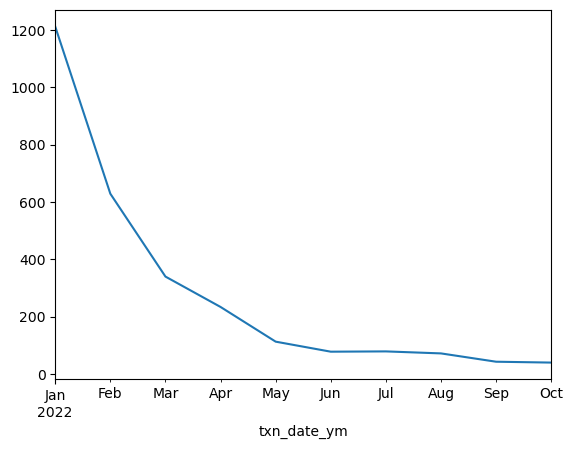

In [32]:
# As expected, the number of customers drops as time goes by.
co_summary['user_id'].plot()

### Split into Train and Test Dataset
What is the probability of a customer to make a purchase in the next 30 days (Classification). 

Train dataset will be first 3 months and test data fourth month.

In [33]:
co.head()

,txn_id,user_id,txn_date,txn_date_ym,amount_usd
0,4e5ef0e1-f2af-46c5-8e0b-f0b660c6ca78,bf08436c-ce8b-d915-81d4-b856b592da2b,2022-10-27,2022-10,27.22
1,d1f625c8-b500-4a82-9bb9-07153938a0b0,bf08436c-ce8b-d915-81d4-b856b592da2b,2022-10-27,2022-10,27.22
2,46c64a67-0176-4a4f-8fdd-8eacf19c723f,154deef2-1a3e-1ccc-4df8-2d2f4e9ce3ce,2022-10-27,2022-10,19.06
3,cea9e271-7093-46c1-a3ed-a52a9c620047,02732a69-3c04-fc45-37a4-524c36e673a4,2022-10-27,2022-10,272.25
4,f6f07595-e285-4c62-950f-dc862d987032,bf08436c-ce8b-d915-81d4-b856b592da2b,2022-10-27,2022-10,81.67


In [34]:
# Setting train and test split date
co_final = co[(co['txn_date_ym'] >= '2022-01') & (co['txn_date_ym'] <= '2022-04')]
co_final.head()

,txn_id,user_id,txn_date,txn_date_ym,amount_usd
2405,67c1a716-e513-41ec-89b3-5444b85515dc,03b6fdda-bf26-f1a4-6598-7e1c0353384d,2022-04-30,2022-04,27.22
2406,3e5dea77-85b8-4630-9132-a56757ec5e5e,ff110353-08be-3622-1389-a6ed25fca0d5,2022-04-30,2022-04,408.37
2407,0ab43f94-75e4-4af8-8d1b-4ff1499abea8,4536e929-ef6f-c1b4-3d3e-97c22d5bdbce,2022-04-30,2022-04,5.44
2408,c08039c0-fb41-4719-955e-9d56fee57870,b69606cd-e6e5-ebe9-619a-16ff69f6db8b,2022-04-30,2022-04,54.45
2409,469d50a8-8494-4d73-b161-6069e94bd43a,21d9c77b-4de5-04e0-1405-e431949b1f95,2022-04-30,2022-04,49.82


In [35]:
cutoff = co_final.txn_date.max() - pd.to_timedelta(30, unit='d')
cutoff

Timestamp('2022-03-31 00:00:00')

In [36]:
# Splitting into train and test. first split, raw.
x_raw = co_final[co_final['txn_date'] < cutoff]
y_raw = co_final[co_final['txn_date'] >= cutoff]
print('Train split %:', round(len(x_raw)/len(co_final), 2), '\nTest split %:', round(len(y_raw)/len(co_final), 2))

Train split %: 0.91 
Test split %: 0.09


### Creating Y true

In [37]:
def create_ytrue(df):
    y = df.groupby('user_id')[['amount_usd']].sum().set_axis(['true_amnt_spent'], axis=1)
    y['is_active'] = 1
    return y

y = create_ytrue(y_raw)

In [38]:
y = y_raw.groupby('user_id')[['amount_usd']].sum().set_axis(['true_amnt_spent'], axis=1)
y['is_active'] = 1
y.head()

,true_amnt_spent,is_active
user_id,,
01369992-5bd0-7d67-af03-54b63d931927,19.05,1
02732a69-3c04-fc45-37a4-524c36e673a4,217.80,1
02e99862-3b2b-6c20-8c66-27c57f90bccb,1184.26,1
0377f0e0-732e-c233-41e7-55a930cb3eea,1334.01,1
03b6fdda-bf26-f1a4-6598-7e1c0353384d,163.33,1


### Feature engineering for Train (X) dataset

**Recency**

In [39]:
def recency(df):
    
    def last_buy_days(x, compare_to):
        val = compare_to - x.max()[1]
        return val.days
    
    oldest_date = df.txn_date.max()
    
    grp = df.groupby('user_id')[['user_id', 'txn_date']].apply(lambda x: last_buy_days(x, oldest_date))
    recency = grp.to_frame().set_axis(['recency'], axis=1)
    return recency

recency_df = recency(x_raw)
recency_df.head()

,recency
user_id,
0051848f-4b98-a499-04fb-d5456ded042c,43
008df191-064f-00ef-b049-0d17766ea839,69
00dbbdcf-13de-31e1-5210-b99784054556,87
00dd0436-3916-1186-e8c6-3b51be838522,50
00e71582-bc91-cb82-2eab-0542d48ad937,43


**Frequency**

In [40]:
def frequency(df):
    return df.groupby('user_id')['txn_date'].count().to_frame().set_axis(['frequency'], axis=1)
                                                                         
frequency_df = frequency(x_raw)
frequency_df.head()

,frequency
user_id,
0051848f-4b98-a499-04fb-d5456ded042c,29
008df191-064f-00ef-b049-0d17766ea839,1
00dbbdcf-13de-31e1-5210-b99784054556,3
00dd0436-3916-1186-e8c6-3b51be838522,4
00e71582-bc91-cb82-2eab-0542d48ad937,29


**Average and Sum spent**

In [41]:
def monetary_value(df):
    return df.groupby('user_id')[['amount_usd']].agg(['sum', 'mean']).set_axis(['price_sum', 'price_mean'], axis=1)

mv_df = monetary_value(x_raw)
mv_df.head()

,price_sum,price_mean
user_id,,
0051848f-4b98-a499-04fb-d5456ded042c,3981.69,137.299655
008df191-064f-00ef-b049-0d17766ea839,499.58,499.580000
00dbbdcf-13de-31e1-5210-b99784054556,1004.87,334.956667
00dd0436-3916-1186-e8c6-3b51be838522,882.09,220.522500
00e71582-bc91-cb82-2eab-0542d48ad937,9141.80,315.234483


In [42]:
# Merging X datasets

In [43]:
# Merging X datasets

def df_merger(dfs):
    return pd.concat(dfs, axis=1)

x = df_merger([recency_df, frequency_df, mv_df])
x.head()

,recency,frequency,price_sum,price_mean
user_id,,,,
0051848f-4b98-a499-04fb-d5456ded042c,43,29,3981.69,137.299655
008df191-064f-00ef-b049-0d17766ea839,69,1,499.58,499.580000
00dbbdcf-13de-31e1-5210-b99784054556,87,3,1004.87,334.956667
00dd0436-3916-1186-e8c6-3b51be838522,50,4,882.09,220.522500
00e71582-bc91-cb82-2eab-0542d48ad937,43,29,9141.80,315.234483


### Train test split. Defining X and y datasets.

In [44]:
xy = x.join(y, how='left').fillna(0)
xy.head()

,recency,frequency,price_sum,price_mean,true_amnt_spent,is_active
user_id,,,,,,
0051848f-4b98-a499-04fb-d5456ded042c,43,29,3981.69,137.299655,0.0,0.0
008df191-064f-00ef-b049-0d17766ea839,69,1,499.58,499.580000,0.0,0.0
00dbbdcf-13de-31e1-5210-b99784054556,87,3,1004.87,334.956667,0.0,0.0
00dd0436-3916-1186-e8c6-3b51be838522,50,4,882.09,220.522500,0.0,0.0
00e71582-bc91-cb82-2eab-0542d48ad937,43,29,9141.80,315.234483,0.0,0.0


In [45]:
x = xy[['recency', 'frequency', 'price_sum', 'price_mean']]
x.head()

,recency,frequency,price_sum,price_mean
user_id,,,,
0051848f-4b98-a499-04fb-d5456ded042c,43,29,3981.69,137.299655
008df191-064f-00ef-b049-0d17766ea839,69,1,499.58,499.580000
00dbbdcf-13de-31e1-5210-b99784054556,87,3,1004.87,334.956667
00dd0436-3916-1186-e8c6-3b51be838522,50,4,882.09,220.522500
00e71582-bc91-cb82-2eab-0542d48ad937,43,29,9141.80,315.234483


In [46]:
y_reg = xy['true_amnt_spent']
y_cls = xy['is_active']
y_cls.head()

user_id
0051848f-4b98-a499-04fb-d5456ded042c    0.0
008df191-064f-00ef-b049-0d17766ea839    0.0
00dbbdcf-13de-31e1-5210-b99784054556    0.0
00dd0436-3916-1186-e8c6-3b51be838522    0.0
00e71582-bc91-cb82-2eab-0542d48ad937    0.0
Name: is_active, dtype: float64

In [47]:
# Train Test Split
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, test_size=0.2, random_state=42)
x_train_cls, x_test_cls, y_train_cls, y_test_cls = train_test_split(x, y_cls, test_size=0.2, random_state=42)

print(f'Train dataset size: {len(x_train_cls)}\nTest dataset size: {len(x_test_cls)}')

Train dataset size: 1154
Test dataset size: 289


### Fitting and Testing the Machine Learning model
### Scikit-Learn Random Forest Classifier
### Simple model. No hyperparameter tuning. 

#### Fitting Train data

In [48]:
model = RandomForestClassifier(random_state=42)

model.fit(x_train_cls, y_train_cls)
y_pred = pd.DataFrame(model.predict(x_train_cls), columns=['y_pred'])

y_true = pd.DataFrame(y_train_cls.values, columns=['y_true'])

accuracy_score(y_true['y_true'], y_pred['y_pred'])

0.9974003466204506

#### Fitting Test data

In [49]:
model = RandomForestClassifier(random_state=42)

model.fit(x_train_cls, y_train_cls)
y_pred = pd.DataFrame(model.predict(x_test_cls), columns=['y_pred'])

y_true = pd.DataFrame(y_test_cls.values, columns=['y_true'])


accuracy_score(y_true['y_true'], y_pred['y_pred'])

0.8996539792387543

#### Feature importance

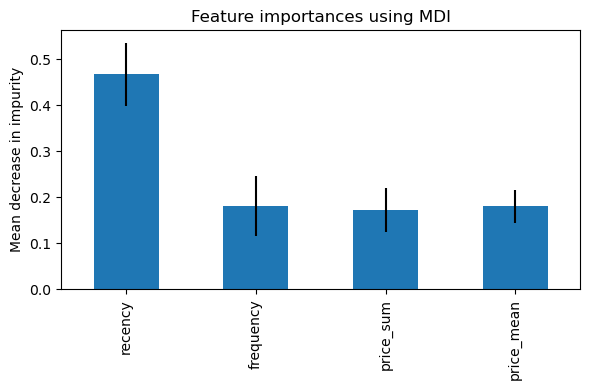

In [50]:
importances = model.feature_importances_

std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=x.columns)

fig, ax = plt.subplots(figsize=(6,4))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [51]:
# Creating df with x features, y true and y pred
final = pd.concat([x_test_cls.reset_index(drop=False), y_true, y_pred], axis=1)
final.head()

,user_id,recency,frequency,price_sum,price_mean,y_true,y_pred
0,458bcf9f-2495-676b-5955-a0d1bfd98664,70,8,2384.88,298.110000,0.0,0.0
1,33b20994-3275-1f99-c6c5-d63cac9f565e,12,79,19178.03,242.759873,0.0,0.0
2,b6f27175-23c1-0843-2d4b-20190a08cf57,87,2,1038.36,519.180000,0.0,0.0
3,0beb9726-3163-0140-f838-12c875b2d8c8,68,1,5.44,5.440000,0.0,0.0
4,b5816865-1701-5e9a-e90e-9fe62940e521,37,22,9260.59,420.935909,0.0,0.0


### Business Questions

This model is used to check what the user should have done but didn't. It does not attempt to predict future performance but rather check what the user should have done. If the user didnt behave like expected (didnt perform any transaction) we could entice them to do so with additional marketing messages targeted to these customers.

For example, the user `a8b2b5ff-08aa-74b7-b985-7413ee92b3ee` was expected to do something but didnt. This customer has a low frequency and recency. This user should be targeted by the marketing team to keep him using the service.

In [52]:
final[final['y_pred'] == 1].sort_values('recency', ascending=True).head()

,user_id,recency,frequency,price_sum,price_mean,y_true,y_pred
11,93eb1b74-24d8-2323-bbb8-7947618bb320,0,2,28.58,14.290000,1.0,1.0
221,ad773c25-cdbb-d4f7-c6a6-8c217a825c65,0,91,18348.93,201.636593,1.0,1.0
121,5a47874d-6af7-fdd8-d5ce-83d97548f0f5,0,50,5040.88,100.817600,1.0,1.0
135,e50f97f9-e3c8-7d11-59ef-8ec016495d75,1,4,479.15,119.787500,1.0,1.0
114,839aa466-6f9f-d25d-f9b6-160497cadf9b,1,61,21510.25,352.627049,1.0,1.0


In [53]:
ae[ae['user_id'] == 'a8b2b5ff-08aa-74b7-b985-7413ee92b3ee']

,txn_id,txn_date,txn_type,amount_usd,user_id,user_date,txn_date_ym,user_date_ym
8005,9a011aff-f92c-4e75-94a2-2f7eeece08ba,2022-09-27,load using bank card,190.57,a8b2b5ff-08aa-74b7-b985-7413ee92b3ee,2022-07-22,2022-09,2022-07
8008,b207f171-c79d-4289-9a72-8e3ec6f9fd04,2022-09-27,load using bank card,19.99,a8b2b5ff-08aa-74b7-b985-7413ee92b3ee,2022-07-22,2022-09,2022-07
10449,4b49ccec-59f0-4d5b-92fe-8dbe3ad93cd4,2022-09-14,load using bank card,176.96,a8b2b5ff-08aa-74b7-b985-7413ee92b3ee,2022-07-22,2022-09,2022-07
18063,f72f6fa6-cee5-4e9a-befb-2f19ea9b69d8,2022-07-23,load using bank card,5.44,a8b2b5ff-08aa-74b7-b985-7413ee92b3ee,2022-07-22,2022-07,2022-07
18065,7080351a-a390-4667-b195-75035288e7c0,2022-07-23,load using bank card,190.57,a8b2b5ff-08aa-74b7-b985-7413ee92b3ee,2022-07-22,2022-07,2022-07


In [54]:
# Analyse the money as well. Those who should have spent but didnt